# Features Importance Using Deep & Cross Network on ML-1m in TFRS

## Setup

In [ ]:
!pip install -q tensorflow_recommenders

     |████████████████████████████████| 85 kB 2.4 MB/s 


In [ ]:
import os
import pprint
import tempfile
import matplotlib.pyplot as plt
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Dict, Text
import pandas as pd
import numpy as np

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

plt.style.use('ggplot')

## Data Loading and Processing

In [ ]:
# Ratings data.
ratings = tfds.load("movielens/1m-ratings", split="train", shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/1m-ratings/0.1.0.incomplete7B5QAC/movielens-train.tfrecord


  0%|          | 0/1000209 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/1m-ratings/0.1.0. Subsequent calls will reuse this data.


In [ ]:
#The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:
#View the data from ratings dataset:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 35.0,
 'movie_genres': array([0, 7]),
 'movie_id': b'3107',
 'movie_title': b'Backdraft (1991)',
 'timestamp': 977432193,
 'user_gender': True,
 'user_id': b'130',
 'user_occupation_label': 18,
 'user_occupation_text': b'technician/engineer',
 'user_rating': 5.0,
 'user_zip_code': b'50021'}


Next, we're only going to extract the movie title and the user id. So, we're actually not going to extract the rating itself and the reason why is that we're treating these as implicit recommendations in this case because that's easier to do a large scale like we mentioned earlier we want to try to keep things simple in the retrieval stage because it's operating over potentially a massive amount of data so to that end we're just going to assume that any movie that a user rated is one that they were really interested in if they took the time to watch it then it expresses some level of interest:

In [ ]:
#Let's select the necessary attributes:

ratings = ratings.map(lambda x: {
                                 "movie_id": x["movie_id"],
                                 "user_id": x["user_id"],
                                 "user_rating": x["user_rating"],
                                 "user_gender": int(x["user_gender"]),
                                 "user_zip_code": x["user_zip_code"],
                                 "user_occupation_text": x["user_occupation_text"],
                                 "bucketized_user_age": int(x["bucketized_user_age"]),                                
                                })

In [ ]:
# let's use a random split, putting 75% of the ratings in the train set, and 25% in the test set:
# Assign a seed=42 for consistency of results and reproducibility:
seed = 42
l = len(ratings)

tf.random.set_seed(seed)
shuffled = ratings.shuffle(l, seed=seed, reshuffle_each_iteration=False)

#Save 75% of the data for training and 25% for testing:
train_ = int(0.75 * l)
test_ = int(0.25 * l)

train = shuffled.take(train_)
test = shuffled.skip(train_).take(test_)

In [ ]:
#Then, let's create vocabulary for each feature:

feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
    vocab = ratings.batch(l).map(lambda x: x[feature_name])
    vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

## Model Definition

The model architecture we will be building starts with an embedding layer, which is fed into a cross network followed by a deep network. The embedding dimension is set to 32 for all the features. You could also use different embedding sizes for different features.

In [ ]:
class DCN(tfrs.Model):
    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
        super().__init__()

        self.embedding_dimension = 32

        str_features = ["movie_id", "user_id", "user_zip_code",
                        "user_occupation_text"]
        int_features = ["user_gender", "bucketized_user_age"]

        self._all_features = str_features + int_features
        self._embeddings = {}

        # Compute embeddings for string features.
        for feature_name in str_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                                                                [tf.keras.layers.experimental.preprocessing.StringLookup(
                                                                 vocabulary=vocabulary, mask_token=None),
                                                                 tf.keras.layers.Embedding(len(vocabulary) + 1,
                                                                 self.embedding_dimension)
                                           ])
      
        # Compute embeddings for int features.
        for feature_name in int_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                                                                 [tf.keras.layers.experimental.preprocessing.IntegerLookup(
                                                                 vocabulary=vocabulary, mask_value=None),
                                                                 tf.keras.layers.Embedding(len(vocabulary) + 1,
                                                                 self.embedding_dimension)
                                           ])

        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(
                                                      projection_dim=projection_dim,
                                                      kernel_initializer="glorot_uniform")
        else:
            self._cross_layer = None

        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layer_sizes]

        self._logit_layer = tf.keras.layers.Dense(1)

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
            )

    def call(self, features):
        # Concatenate embeddings
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))

        x = tf.concat(embeddings, axis=1)

        # Build Cross Network
        if self._cross_layer is not None:
            x = self._cross_layer(x)
    
    # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return self._logit_layer(x)

    def compute_loss(self, features, training=False):
        labels = features.pop("user_rating")
        scores = self(features)
        return self.task(labels=labels,predictions=scores,
        )

## Model Training

In [ ]:
# Then shuffle, batch, and cache the training and evaluation data:
# Segment the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.
cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

Now let's define a function that runs a model multiple times and returns the model's RMSE mean and standard deviation out of multiple runs

In [ ]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
    models = []
    rmses = []

    for i in range(num_runs):
        model = DCN(use_cross_layer=use_cross_layer,
                    deep_layer_sizes=deep_layer_sizes,
                    projection_dim=projection_dim)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
        models.append(model)

        model.fit(cached_train, epochs=epochs, verbose=False)
        metrics = model.evaluate(cached_test, return_dict=True)
        rmses.append(metrics["RMSE"])

    mean, stdv = np.average(rmses), np.std(rmses)

    return {"model": models, "mean": mean, "stdv": stdv}

We set some hyper-parameters for the models. Note that these hyper-parameters are set globally for all the models for demonstration purpose. If you want to obtain the best performance for each model, or conduct a fair comparison among models, then we'd suggest you to fine-tune the hyper-parameters. Remember that the model architecture and optimization schemes are intertwined.



In [ ]:
epochs = 2
learning_rate = 0.01

We first train a DCN model with a stacked structure, that is, the inputs are fed to a cross network followed by a deep network.

In [ ]:
dcn_result = run_models(use_cross_layer=True, deep_layer_sizes=[192, 192])

123/123 [==============================] - 2s 14ms/step - RMSE: 0.8861 - loss: 0.7856 - regularization_loss: 0.0000e+00 - total_loss: 0.7856


Visualizing the Weight Matrix Learned by DCN


<Figure size 864x864 with 0 Axes>

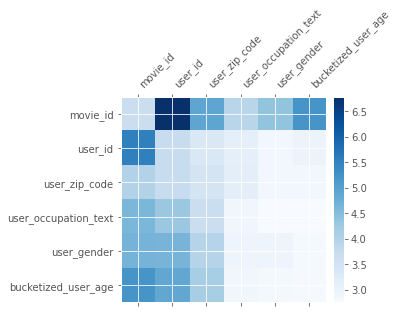

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])
dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
    for j in range(len(features)):
        block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
        block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(12,12))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)
#plt.title('Visualizing the Weight Matrix Learned by DCN')
print('Visualizing the Weight Matrix Learned by DCN')

One of the nice things about DCN is that you can visualize the weights from the cross network and see if it has successfully learned the important feature process. As shown above, the stronger the interaction between two features is. In this case, the feature cross of user ID and movie ID is of great importance.



To reduce the training and serving cost, we leverage low-rank techniques to approximate the DCN weight matrices. The rank is passed in through argument projection_dim; a smaller projection_dim results in a lower cost. Note that projection_dim needs to be smaller than (input size)/2 to reduce the cost. In practice, we've observed using low-rank DCN with rank (input size)/4 consistently preserved the accuracy of a full-rank DCN.

In [ ]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

123/123 [==============================] - 2s 14ms/step - RMSE: 0.8878 - loss: 0.7892 - regularization_loss: 0.0000e+00 - total_loss: 0.7892


We train a same-sized DNN model as a reference.

In [ ]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

123/123 [==============================] - 2s 16ms/step - RMSE: 0.9062 - loss: 0.8212 - regularization_loss: 0.0000e+00 - total_loss: 0.8212


In [ ]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 0.8865, stdv: 0.0020
DCN (low-rank) RMSE mean: 0.8890, stdv: 0.0016
DNN            RMSE mean: 0.8948, stdv: 0.0106
